# Messtechnik HS2021 - Tutorial 3


In [3]:
import numpy as np
import matplotlib.pyplot as plt 

# Fourier transformation 
def compute_fft(t,X):
    """ Manually compute the FT of a simple signal"""
    t = np.atleast_1d(t)
    X = np.atleast_1d(X)
    # Construct grid of points for spectrum
    N = np.size(t)
    grid = np.arange(N)
    dt = (max(t) - min(t))/(N - 1)
    # Frequency axis
    omega = 4*np.pi/N*grid
    # Shift zero-frequency component to center of spectrum
    omega = omega - 0.5*max(omega)
    # Scale by Nyquist criterion
    omega = omega/(2*dt)
    # Calculate Fourier transform operator
    FToperator = np.exp(-1j*np.outer(omega.T,t))
    # Transform signal
    Y = FToperator@X
    return omega,Y

# Inverse Fourier transformation 
def compute_ifft(t,omega,X):
    """ Manually compute the FT of a simple signal"""
    t = np.atleast_1d(t)
    omega = np.atleast_1d(omega)
    X = np.atleast_1d(X)
    # Calculate Fourier transform operator
    FToperator = np.exp(+1j*np.outer(t,omega.T))
    # Transform signal
    Y = FToperator@X
    return Y



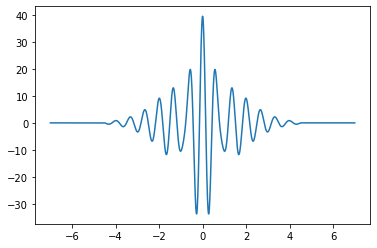

C:\Users\Luis\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


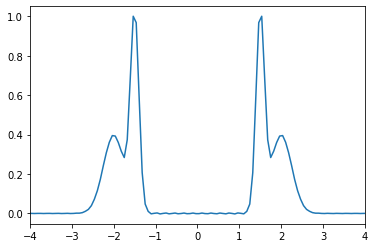

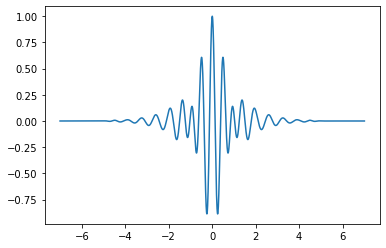

C:\Users\Luis\AppData\Roaming\Python\Python39\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


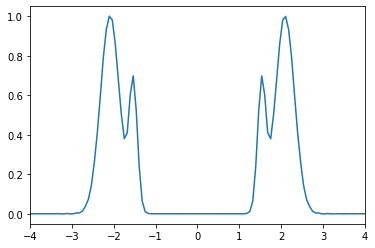

In [66]:

t = np.linspace(-7,7,4000)

pulse_ = np.array([0 if abs(time)>4.5 else 1 for time in t]) 

nu = np.linspace(0,5,100)
mu = 2 # center around zero
sigma = 0.25 # width parameter
gauss = 1/(sigma*np.sqrt(2*np.pi))*np.exp( - (nu - mu)**2 / (2*sigma**2))

mu = 1.5 # center around zero
sigma = 0.1 # width parameter
gauss2 = 1/(sigma*np.sqrt(2*np.pi))*np.exp( - (nu - mu)**2 / (2*sigma**2))

pulse = 0
for freq,amp in zip(nu,gauss):
    pulse = pulse + amp*pulse_*np.cos(2*np.pi*freq*t)
for freq,amp in zip(nu,gauss2):
    pulse = pulse + amp*pulse_*np.cos(2*np.pi*freq*t)
plt.plot(t,pulse)
plt.show()
freq,spec = compute_fft(t,pulse)
freq = freq/2/np.pi
plt.plot(freq,spec/max(spec))
plt.xlim([-4,4])
plt.show()

mu = 0 
sigma = 0.3
P = 1/(sigma*np.sqrt(2*np.pi))*np.exp( - (t - mu)**2 / (2*sigma**2))*np.cos(np.pi*2*t*2.5)
pulse_out = np.convolve(pulse,P,mode='same')

pulse_out = pulse_out/max(pulse_out)
pulse = pulse/max(pulse)

plt.plot(t,pulse_out)
plt.show()
freq,spec = compute_fft(t,pulse_out)
freq = freq/2/np.pi
plt.plot(freq,spec/max(spec))
plt.xlim([-4,4])
plt.show()


np.savez('pulses',t=t,input=pulse,output=pulse_out)






# Aufgabe 1: Lineare Antwort
----------------------


Gegeben ist einen Input EM-Puls $ x(t) $ der durch einen Kabel zum Spektrometer geschickt wird. Am Ende des Kabels wird der Output Puls $ y(t) $ neu gemessen. 
Die Input und Output Pulsen sind in der Numpy-formattierte Datei `pulses.npz` gespeichert.  

1) Plotten Sie die gemessene Pulsen. Welche Unterschieden sehen Sie? 
2) Berechnen und vergleichen Sie die Pulsen im Frequenzbereich. Benutzen Sie dafür die vorgegebene Funktion `compute_fft`.
3) Berechnen Sie die Antwortsfunktion des Kabels. Benutzen Sie dafür die vorgegebene Funktion `compute_ifft`. 
4) Wie würden Sie die gewünschte Puls-Form im Spektrometer erreichen?   


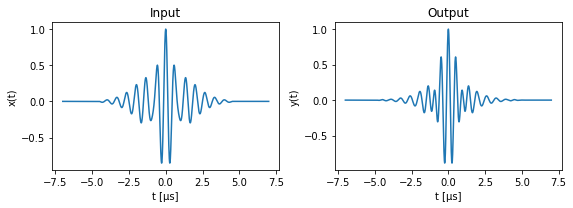

In [67]:
# Load external data file
data = np.load('pulses.npz')
# Extract the variables
t = data['t']
pulse_input = data['input']
pulse_output = data['output']

plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(t,pulse_input)
plt.xlabel('t [μs]')
plt.ylabel('x(t)')
plt.title('Input')

plt.subplot(122)
plt.plot(t,pulse_output)
plt.xlabel('t [μs]')
plt.ylabel('y(t)')
plt.title('Output')

plt.tight_layout()
plt.show()

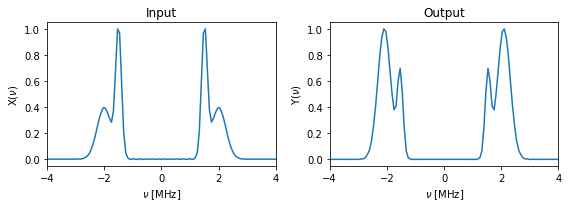

In [68]:
# Compute the spectra (via Fourier transform)
freq,spec_input = compute_fft(t,pulse_input)
_,spec_output = compute_fft(t,pulse_output)

# Angular frequencies -> Linear frequencies
freq = freq/2/np.pi

# Normalize the spectra to their maximum
spec_input = spec_input/max(spec_input)
spec_output = spec_output/max(spec_output)

plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(freq,spec_input.real)
plt.xlim([-4,4])
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel(r'X($\nu$)')
plt.title('Input')

plt.subplot(122)
plt.plot(freq,spec_output.real)
plt.xlim([-4,4])
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel(r'Y($\nu$)')
plt.title('Output')

plt.tight_layout()
plt.show()

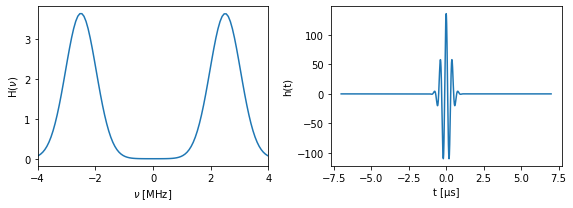

In [71]:
# Calculate the impulse reponse function
transferfcn_spec = spec_output/spec_input
transferfcn = compute_ifft(t,freq*2*np.pi,transferfcn_spec).real

plt.figure(figsize=[8,3])
plt.subplot(121)
plt.plot(freq,transferfcn_spec.real)
plt.xlim([-4,4])
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel(r'H($\nu$)')

plt.subplot(122)
plt.plot(t,transferfcn)
plt.xlabel('t [μs]')
plt.ylabel('h(t)')

plt.tight_layout()
plt.show()

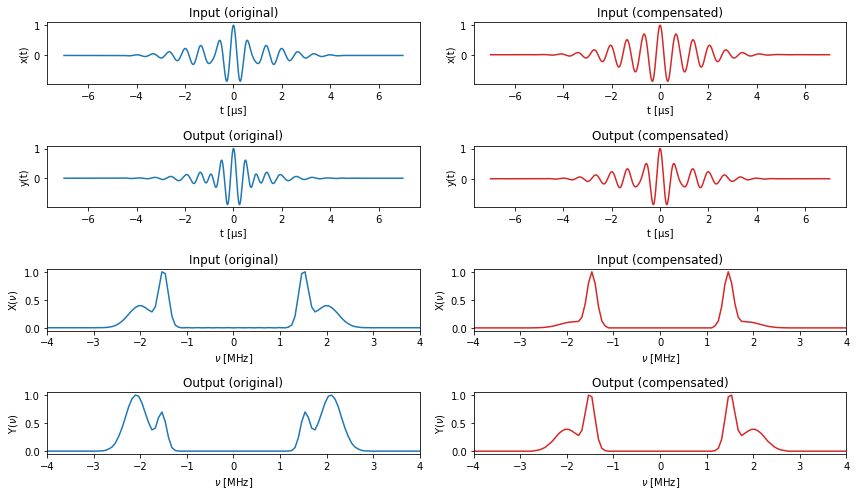

In [80]:

# Compute the compensated input pulse
pulse_input_new = compute_ifft(t,freq*2*np.pi,np.round(spec_input,2)/transferfcn_spec)
_,spec_input_new = compute_fft(t,pulse_input_new)

# Calculate the new output pulse
pulse_output_new = compute_ifft(t,freq*2*np.pi,spec_input_new*transferfcn_spec)
_,spec_output_new = compute_fft(t,pulse_output_new)


# Normalize for clearer plots
pulse_input_new = pulse_input_new/max(pulse_input_new)
pulse_input = pulse_input/max(pulse_input)

pulse_output = pulse_output/max(pulse_output)
pulse_output_new = pulse_output_new/max(pulse_output_new)

spec_input = spec_input/max(spec_input)
spec_input_new = spec_input_new/max(spec_input_new)

spec_output = spec_output/max(spec_output)
spec_output_new = spec_output_new/max(spec_output_new)

plt.figure(figsize=[12,7])
plt.subplot(421)
plt.plot(t,pulse_input)
plt.xlabel('t [μs]')
plt.ylabel('x(t)')
plt.title('Input (original)')
plt.subplot(422)
plt.plot(t,pulse_input_new.real,'tab:red')
plt.xlabel('t [μs]')
plt.ylabel('x(t)')
plt.title('Input (compensated)')

plt.subplot(423)
plt.plot(t,pulse_output)
plt.xlabel('t [μs]')
plt.ylabel('y(t)')
plt.title('Output (original)')
plt.subplot(424)
plt.plot(t,pulse_output_new.real,'tab:red')
plt.xlabel('t [μs]')
plt.ylabel('y(t)')
plt.title('Output (compensated)')

plt.subplot(425)
plt.plot(freq,spec_input.real)
plt.xlim([-4,4])
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel(r'X($\nu$)')
plt.title('Input (original)')
plt.subplot(426)
plt.plot(freq,spec_input_new.real,'tab:red')
plt.xlim([-4,4])
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel(r'X($\nu$)')
plt.title('Input (compensated)')

plt.subplot(427)
plt.plot(freq,spec_output.real)
plt.xlim([-4,4])
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel(r'Y($\nu$)')
plt.title('Output (original)')
plt.subplot(428)
plt.plot(freq,spec_output_new.real,'tab:red')
plt.xlim([-4,4])
plt.xlabel(r'$\nu$ [MHz]')
plt.ylabel(r'Y($\nu$)')
plt.title('Output (compensated)')

plt.tight_layout()
plt.show()

## Aufgabe 2: Faltung
--------------------

Berechnen Sie numerisch die Faltung einer Rechteckfunktion (box function) mit einer identischen Rechteckfunktion (a) sowie die Faltung einer Rechteckfunktion mit einer Gauss-Funktion (b):  

<center>
<img src="img/img1.png" width=700  />
</center>

Benutzen Sie dazu die Numpy-Funktion ``convolve``. Definieren Sie alle Ausgangfunktionen zwischen $ t = -10 $ und $ t=10 $ mit 2001 Punkten. Konstruieren Sie eine Rechteckfunktion die eine Breite von 18.0 hat und eine Gauss-Funktion mit einer Standardabweichung $ \sigma = 1 $. Die Zeitachse der Faltung soll explizit berechnet werden.\\
\textit{Hinweis:} Um den Vektor $ t $ zu kreieren können Sie den Befehl ``t = np.linspace(-10,10,2001)`` verwenden. Für die Gaussfunktion brauchen sie die foglende Definition: 

\begin{equation}
f(x,\mu,\sigma) = \frac{1}{\sigma \sqrt{2\pi}}\exp\left(-\frac{(x - \mu)^2}{2\sigma^2} \right)
\end{equation}

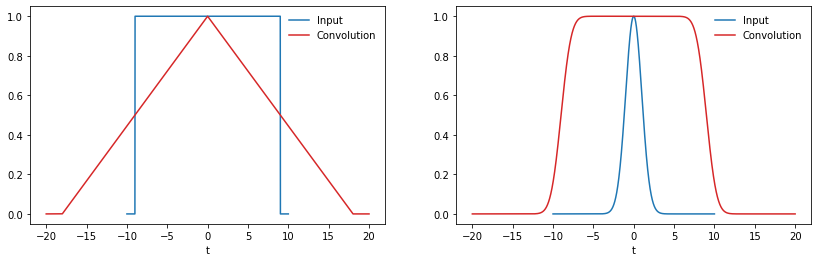

In [341]:
import numpy as np
import matplotlib.pyplot as plt

# Define the axis
N_pts = 2001 # odd number in order to have explicitly a zero point in the spectrum
t_lim = 10
t_box = 18
t = np.linspace(-t_lim,t_lim,N_pts)

# Generate box-function (rechteck-funktion)
boxfcn = np.zeros_like(t)
boxfcn[(t>=-t_box/2) & (t<=t_box/2)] = 1 

# Numerical convolution:
box_box = np.convolve(boxfcn,boxfcn,'full')
box_box = box_box/max(box_box) # normalize to maximum

# Construct new axis for result (has more points)
n_conv = np.size(box_box) # length of the convolution: equal to m+n-1 (see numpy.convolve help)
t_conv = np.linspace(-2*t_lim,2*t_lim,n_conv)

plt.figure(figsize=[14,4])
plt.subplot(121)
plt.plot(t,boxfcn,'tab:blue',label='Input')
plt.plot(t_conv,box_box,'tab:red',label='Convolution')
plt.legend(loc='upper right',frameon=False)
plt.xlabel('t')

# Generate Gaussian function
mu = 0 # center around zero
sigma = 1 # width parameter
gaussfcn = 1/(sigma*np.sqrt(2*np.pi))*np.exp( - (t - mu)**2 / (2*sigma**2))

# Convolution of the box and the Gaussian functions
box_gauss = np.convolve(boxfcn,gaussfcn)
box_gauss = box_gauss/max(box_gauss)
gaussfcn = gaussfcn/max(gaussfcn)

plt.subplot(122)
plt.plot(t,gaussfcn,'tab:blue',label='Input')
plt.plot(t_conv,box_gauss,'tab:red',label='Convolution')
plt.legend(loc='upper right',frameon=False)
plt.xlabel('t');

## Aufgabe 3: Fourier-Transformation
--------------------


Berechnen Sie numerisch die Fourier Transformierten der folgenden Funktionen:

(a) Rechteckfunktion mit der Breite $ \Delta t = 25.0 $, zentriert um $ t=0 $.

(b) Rechteckfunktion mit der Breite $ \Delta t = 5.0 $, zentriert um $ t = 0 $.

(c) Rechteckfunktion mit der Breite $ \Delta t = 25.0 $, zentriert um $ t=0 $, multipliziert mit einer harmonischen Funktion $ \cos(2\pi t) $, mit $ \nu = 1.0 $.

(d) Rechteckfunktion mit der Breite $ \Delta t = 5.0 $, zentriert um $ t=25 $.

*Hinweis:* Verwenden Sie für Ihre Berechnungen die folgende Zeitachse: 
``t = np.linspace(-50,50,4096); # Zeitachse der Fourier Transformation``

<center>
<img src="img/img4.png" width=600  />
</center>

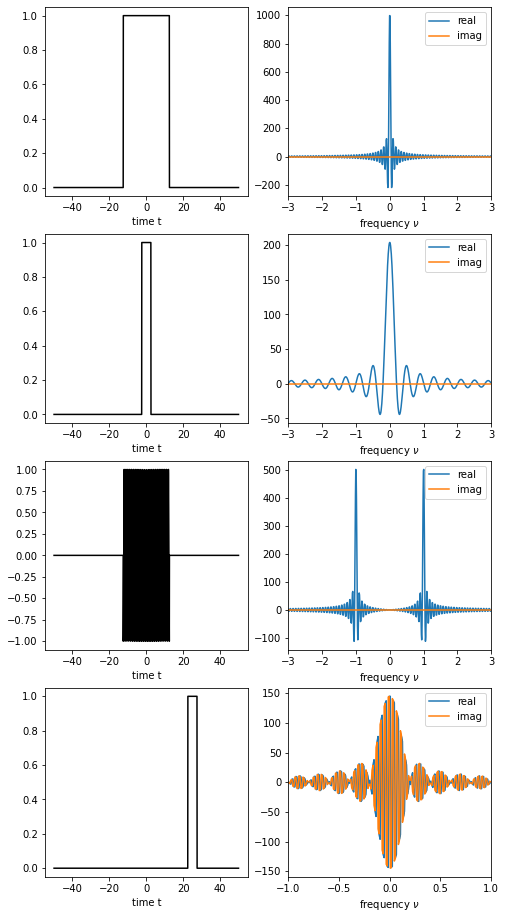

In [340]:
# Since we need different box-functions with different parameters 
# it is useful to define a function to do it
def boxfcn(t,width,shift):
    box = np.zeros_like(t)
    lower_side = -width/2 + shift
    upper_side = width/2 + shift
    box[(t>=lower_side) & (t<=upper_side)] = 1 
    return box

# Define time axis
t = np.linspace(-50,50,4096)

# (a)
#---------------------------------------------
fun = boxfcn(t,25,0)
omega,Y = compute_fft(t,fun)

plt.figure(figsize=[8,16])
plt.subplot(421)
plt.plot(t,fun,'k')
plt.xlabel('time t')

plt.subplot(422)
plt.plot(omega/(2*np.pi),np.real(Y))
plt.plot(omega/(2*np.pi),np.imag(Y))
plt.xlim([-3,3])
plt.xlabel('frequency $\\nu$')
plt.legend(['real','imag'])

# (b)
#---------------------------------------------
fun = boxfcn(t,5,0)
omega,Y = compute_fft(t,fun)

plt.subplot(423)
plt.plot(t,fun,'k')
plt.xlabel('time t')

plt.subplot(424)
plt.plot(omega/(2*np.pi),np.real(Y))
plt.plot(omega/(2*np.pi),np.imag(Y))
plt.xlim([-3,3])
plt.xlabel('frequency $\\nu$')
plt.legend(['real','imag'])

# (c)
#---------------------------------------------
nu = 1
fun = boxfcn(t,25,0)*np.cos(2*np.pi*nu*t)
omega,Y = compute_fft(t,fun)

plt.subplot(425)
plt.plot(t,fun,'k')
plt.xlabel('time t')

plt.subplot(426)
plt.plot(omega/(2*np.pi),np.real(Y))
plt.plot(omega/(2*np.pi),np.imag(Y))
plt.xlim([-3,3])
plt.xlabel('frequency $\\nu$')
plt.legend(['real','imag'])

# (d)
#---------------------------------------------
fun = boxfcn(t,5,25)
omega,Y = compute_fft(t,fun)

plt.subplot(427)
plt.plot(t,fun,'k')
plt.xlabel('time t')

plt.subplot(428)
plt.plot(omega/(2*np.pi),np.real(Y))
plt.plot(omega/(2*np.pi),np.imag(Y))
plt.xlim([-1,1])
plt.xlabel('frequency $\\nu$')
plt.legend(['real','imag']);